In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Basic Libraries

In [3]:
import random
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
import cv2

# Loading the data

In [4]:
df_train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
df_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [5]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Example Images-Visualising The Data

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64


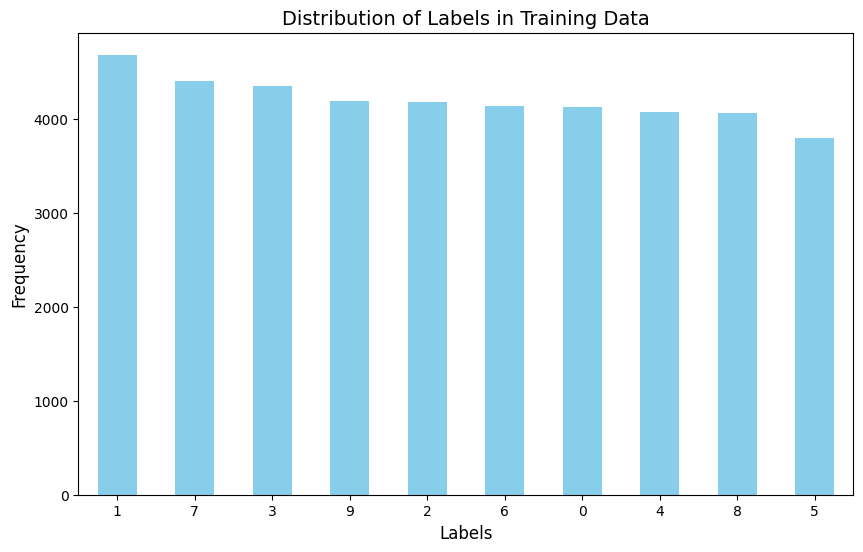

In [7]:
labels = df_train.iloc[:, 0]  # Assuming first column has the labels
print(labels.value_counts())  # Check distribution of digits

# Create a bar chart
plt.figure(figsize=(10, 6))
labels.value_counts().plot(kind='bar', color='skyblue')

plt.title('Distribution of Labels in Training Data', fontsize=14)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0)
plt.show()

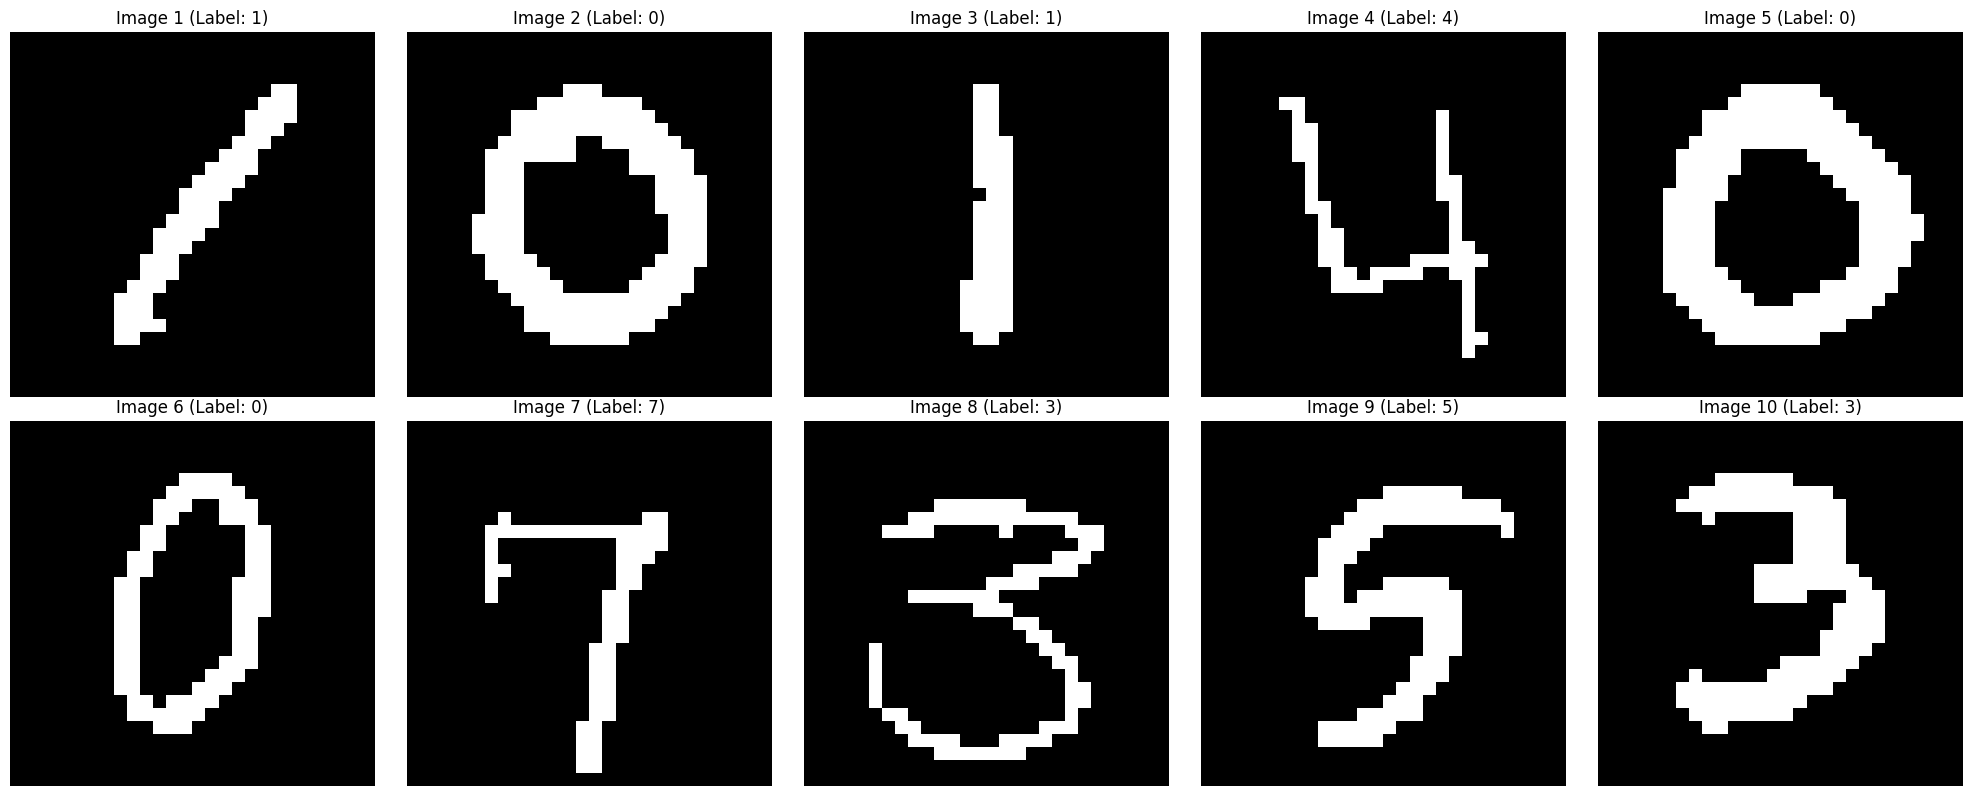

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i in range(10):
    image_data = df_train.iloc[i, 1:].values
    label = df_train.iloc[i, 0]
    
    image_data = image_data.reshape(28, 28,1).astype(np.uint8) 
    _,image_data = cv2.threshold(image_data, 120, 255, cv2.THRESH_BINARY) 
    image_data = image_data.reshape(28, 28)
    row = i // 5
    col = i % 5
    
    axes[row, col].imshow(image_data, cmap='gray')
    axes[row, col].set_title(f'Image {i+1} (Label: {label})')
    axes[row, col].axis('off') 

plt.tight_layout()
plt.show()


# Data Pre-Processing
*One of the most important steps in machine learning. Here we transform the data into a form we can work with, we handle NaN/null values(hopefully this dataset is pretty simple, so we are using standard methods)*

*Here we employ:*
1. Standardization: Normalization and standardization are techniques used to scale and transform numerical features in a dataset. Both methods aim to make the features more suitable for machine learning algorithms by bringing them to a common scale
2. Reshaping: The models we are going to use need either 28x28 images or just simple vectors
3. One Hot Encoding: We need categorical data, so as to avoid confusions by the ML algorithms, i.e. the labels "2" and "5" are different but 5 isn't more important than 2, and we need to establish that.
4. Data Splitting: This helps with training. The model has an unknown set of data that it also needs to do well at. Aims to limit overfitting to the training data.
5. Data Augmentation: By introducing rotated and shifted versions of the images in the dataset we virtually increase the training data and help the model generalize better.

In [9]:
def std_pr(x):
    return (x.astype("float32")-x.mean())/x.std()
    

In [10]:
X = df_train.drop(columns="label")
y = df_train['label']

#Reshsaping
x_train = np.reshape(X, (-1, 28, 28, 1))
print(f"Reshaped train shape: {x_train.shape}")

#Standardizing data
x_train = std_pr(x_train)

#One Hot Encoding
y_train = to_categorical(y, num_classes=10)

Reshaped train shape: (42000, 28, 28, 1)


In [11]:
test = np.reshape(df_test, (-1, 28, 28, 1))
test = std_pr(test)
print(test.shape)

(28000, 28, 28, 1)


In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.1, random_state=42)

In [13]:
#Data Augmentation

datagen = ImageDataGenerator(
        rotation_range=5,         # Randomly rotate images by up to 5 degrees
        zoom_range=0.1,            # Randomly zoom images by up to 10%
        width_shift_range=0.1,     # Randomly shift images horizontally by up to 10% of width
        height_shift_range=0.1,    # Randomly shift images vertically by up to 10% of height
)

datagen.fit(x_train)

In [14]:
# Reshape the data to flatten each 28x28 image into a 1D vector of size 784
x_train_flattened = x_train.reshape(x_train.shape[0], -1)  # Shape becomes (42000, 784)
x_val_flattened = x_val.reshape(x_val.shape[0], -1)
test_flattened = test.reshape(test.shape[0], -1)


***Now we are ready to start learning***

# Approach 1- Using a K-Nearest Neighbors Classifier
*This is one of the simplest ML algorithms. It does not learn! It compares images based on a distance function and it groups together similar enough images. Common metrics are the Euclidean and Manhattan distances.*


In [15]:
# Create a K-Nearest Neighbors classifier
knn = KNeighborsClassifier(n_neighbors=5) 

# Train the KNN model
knn.fit(x_train_flattened, y_train)

# Make predictions
y_pred = knn.predict(x_val_flattened)

In [16]:
# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.24%


# Approach 2-Constructing a CNN from scratch 
*Now we will implement a more sophisticated approach, using a CNN, which extracts features from the data and detects patterns in it, ultimately attempting to generalize on the test data set.

***Step 1: Setting up the architecture***

* Convolutional layers: Images are getting fed into them, and 5x5 filters are applied(with 2D-convolution), thus helping the model spot the distinguishing features of each image. Of course the values in the filters are caclulated by training.
* Max Pooling layers: They reduce the dimensions, shift focus to the most important features.
* Dropout layers: Some input values are dropped, counteracting overfitting.
* Flatten layer: Flattens the multi-dimensional output of the last layers, in order to feed it through a "classic" N.N. a.k.a. **F**ully **C**onnected **N**eural **N**etwork.
* Dense layers: Adding fully connected layers.
* Softmax layer: Outputs a probability, from which we decide the label we want to give to the input.


In [17]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax'),
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer = OPTIMIZER,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 887,530 (3.39 MB)

 Trainable params: 887,530 (3.39 MB)

 Non-trainable params: 0 (0.00 B)

***Step 2: Training the model***

*We will train the model based on the train dataset. We are monitoring the accuracy/loss as well as the validation data accuracy/loss* 

In [18]:
EPOCHS=10
BATCH_SIZE=64

history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                   epochs=EPOCHS, batch_size=BATCH_SIZE,
                   verbose=1, validation_data=(x_val, y_val)
                   )

Epoch 1/10


I0000 00:00:1728633784.919865     101 service.cc:145] XLA service 0x7d10b4007780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728633784.919928     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728633784.919935     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 24/591 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2314 - loss: 2.1329 

I0000 00:00:1728633793.061688     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


591/591 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.7980 - loss: 0.5996 - val_accuracy: 0.9833 - val_loss: 0.0598
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9738 - loss: 0.0836 - val_accuracy: 0.9883 - val_loss: 0.0444
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9809 - loss: 0.0612 - val_accuracy: 0.9879 - val_loss: 0.0401
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9853 - loss: 0.0468 - val_accuracy: 0.9876 - val_loss: 0.0307
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9879 - loss: 0.0358 - val_accuracy: 0.9898 - val_loss: 0.0324
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9900 - loss: 0.0330 - val_accuracy: 0.9917 - val_loss: 0.0261
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9913 - loss: 0.0303 - val_accuracy: 0.9924 - val_loss: 0.0281
Epoch 8/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9915 - loss: 0.0274 - val_accuracy: 0.9910 - va

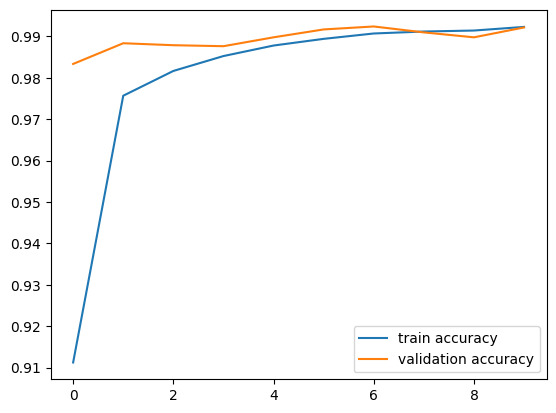

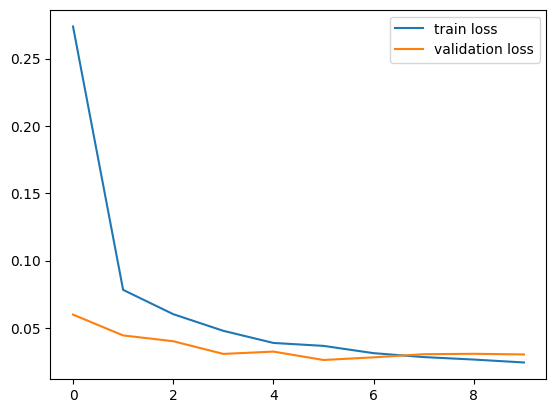

In [19]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


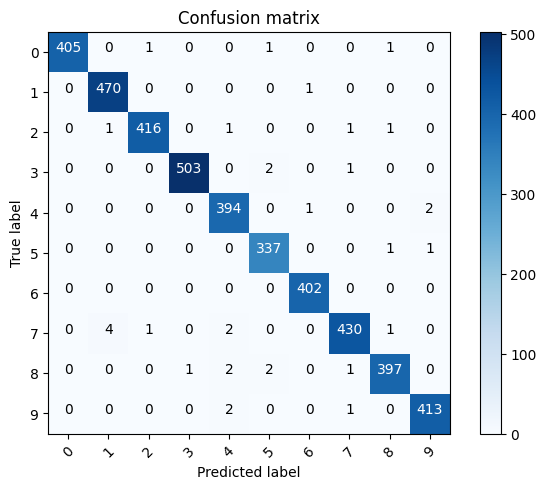

In [31]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

# Making The Final Predictions-Evaluating the model

*Finally, we can put our models to use! We can predict the digits of the test dataset, and get the final result.*

In [20]:
prediction_knn = knn.predict(test_flattened)
result = np.argmax(prediction_knn,axis = 1)
result = pd.Series(result,name="Label")

submission_knn = pd.concat([pd.Series(range(1,28001),name = "ImageId"),result],axis = 1)
submission_knn.sample(10)

,ImageId,Label
12489,12490,6
14943,14944,1
1974,1975,8
18048,18049,0
2808,2809,6
21476,21477,7
25361,25362,0
22494,22495,4
18297,18298,9
4715,4716,1


In [21]:
prediction_cnn = model.predict(test)
result = np.argmax(prediction_cnn,axis = 1)
result = pd.Series(result,name="Label")

submission_cnn = pd.concat([pd.Series(range(1,28001),name = "ImageId"),result],axis = 1)
submission_cnn.sample(10)

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


,ImageId,Label
21753,21754,0
1287,1288,3
21341,21342,9
8571,8572,3
15852,15853,3
23968,23969,4
12271,12272,9
24483,24484,7
26318,26319,5
4602,4603,9



***Example Predictions of the 2 models***

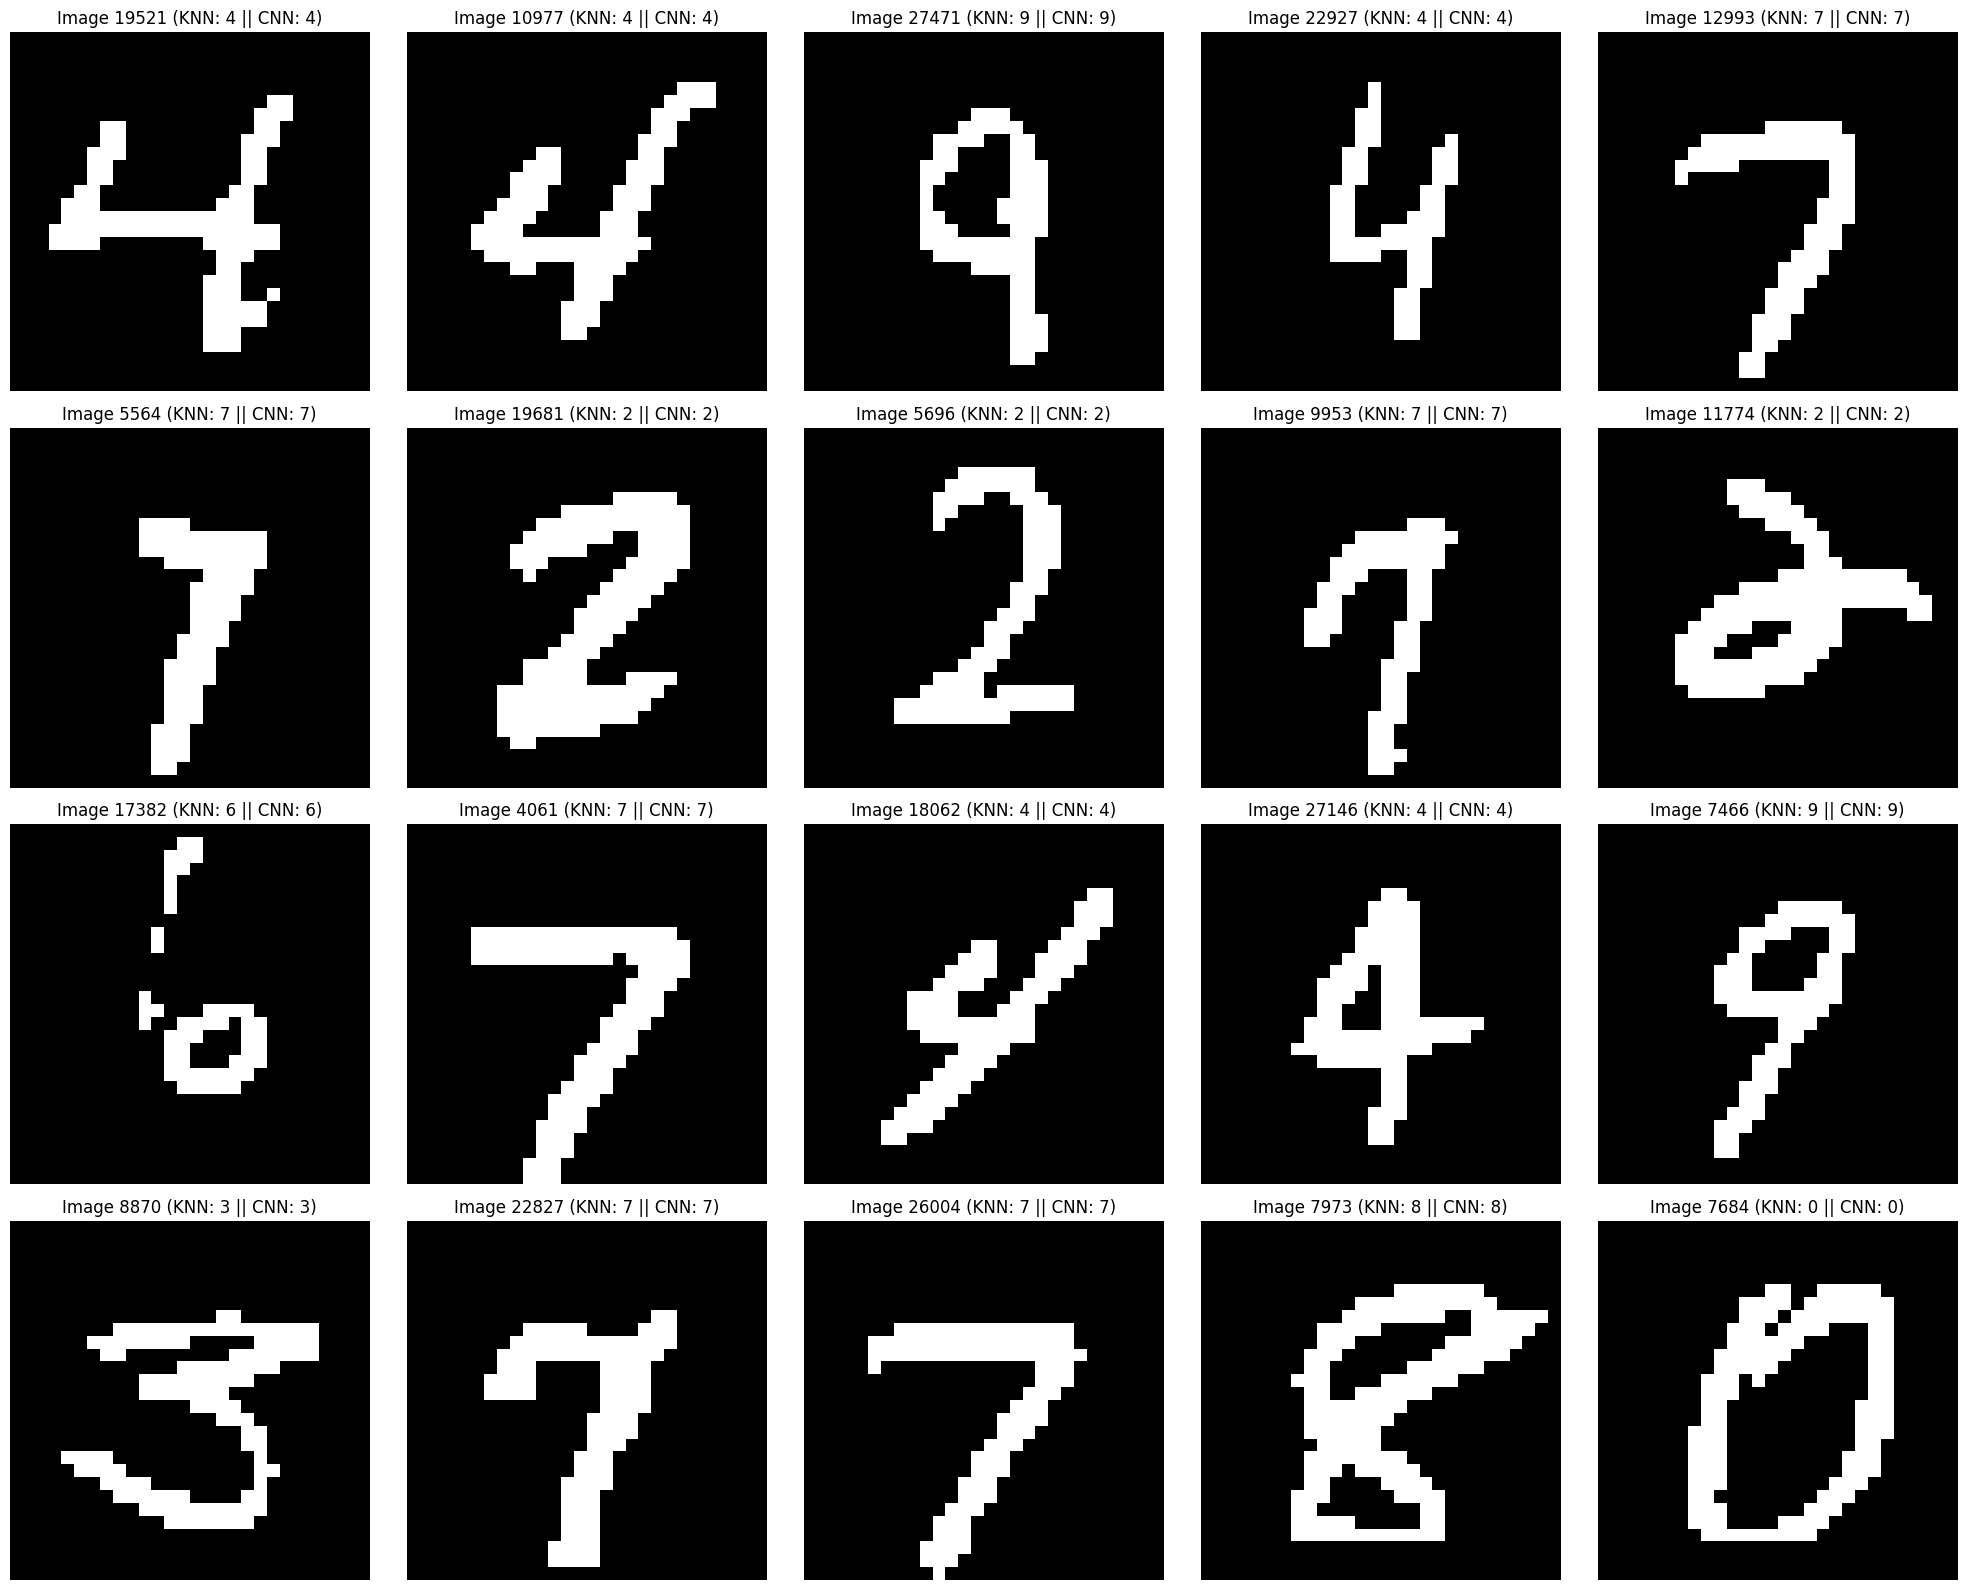

In [26]:
fig, axes = plt.subplots(4, 5, figsize=(20, 16))

for j in range(20):
    i = random.randint(0,28000)
    image_data = df_test.iloc[i].values
    label_knn = submission_knn.iloc[i, 1]
    label_cnn = submission_cnn.iloc[i, 1]
    
    image_data = image_data.reshape(28, 28,1).astype(np.uint8) 
    _,image_data = cv2.threshold(image_data, 120, 255, cv2.THRESH_BINARY) 
    image_data = image_data.reshape(28, 28)
    row = j // 5
    col = j % 5
    
    axes[row, col].imshow(image_data, cmap='gray')
    axes[row, col].set_title(f'Image {i+1} (KNN: {label_knn} || CNN: {label_cnn})')
    axes[row, col].axis('off') 

plt.tight_layout()
plt.show()

In [27]:
submission_cnn.to_csv("/kaggle/working/submission.csv",index=False)

# Appendix-Why KNN works?


Why? 
=>Visble Clusters of same label data/Proximity in the 3d Feature Space!

In [28]:
from sklearn.preprocessing import StandardScaler

X_train = df_train.iloc[:,1:]
y_train = df_train.iloc[:,0]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [29]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=3)
X_train_trf = pca.fit_transform(X_train)
y_train_trf = y_train.astype(str)

fig = px.scatter_3d(x =X_train_trf[:,0], y= X_train_trf[:,1],z=X_train_trf[:,2], color= y_train_trf, color_discrete_sequence= px.colors.qualitative.G10)
fig.show()
